# I. Setup

In [1]:
# import required libs
from os.path import isfile
import pandas as pd
import numpy as np

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [2]:
# setup tensorflow
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.layers.experimental import preprocessing

# detect and init the TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()
print("Number of accelerators: ", strategy.num_replicas_in_sync)
print(strategy)

Tensorflow version 2.6.0
Number of accelerators:  1


In [3]:
# setup plotting
import matplotlib.pyplot as plt
import seaborn as sns

# set Matplotlib defaults
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# II. Data

In [5]:
cols = [
  'ppi', 'width_ratio', 'height_ratio', 'display_screen_size', 'font_height', 'char_width', 'font_dp',
  'density_bucket', 'screen_part', 'element_type','status'
]

X = df[cols].copy()
y = X.pop('status')
y.value_counts()

normal    174086
big         3191
small       1484
Name: status, dtype: int64

In [6]:
# Edit some columns
density_buckets = ['MDPI', 'XHDPI', 'XXXHDPI', 'HDPI', 'XXHDPI']

element_types = ['android.widget.HorizontalScrollView',
 'androidx.cardview.widget.CardView',
 'android.widget.ListView',
 'android.widget.Image',
 'android.widget.EditText',
 'android.webkit.WebView',
 'android.view.View',
 'android.widget.Button',
 'com.android.launcher3.home.Workspace',
 'android.widget.ProgressBar',
 'android.widget.ScrollView',
 'android.widget.CheckedTextView',
 'android.widget.LinearLayout',
 'android.widget.ImageButton',
 'androidx.viewpager.widget.ViewPager',
 'android.view.ViewGroup',
 'android.widget.RelativeLayout',
 'android.widget.TextView',
 'androidx.recyclerview.widget.RecyclerView',
 'android.widget.Switch',
 'android.widget.CheckBox',
 'android.widget.ImageView',
 'android.widget.ToggleButton']

screen_parts = ['body', 'scroll', 'header', 'footer']

In [7]:
X['density_bucket_0'] = 0.0 * len(df)
X['density_bucket_1'] = 0.0 * len(df)
X['density_bucket_2'] = 0.0 * len(df)
X['density_bucket_3'] = 0.0 * len(df)
X['density_bucket_4'] = 0.0 * len(df)


X['element_type_0'] = 0.0 * len(df)
X['element_type_1'] = 0.0 * len(df)
X['element_type_2'] = 0.0 * len(df)
X['element_type_3'] = 0.0 * len(df)
X['element_type_4'] = 0.0 * len(df)
X['element_type_5'] = 0.0 * len(df)
X['element_type_6'] = 0.0 * len(df)
X['element_type_7'] = 0.0 * len(df)
X['element_type_8'] = 0.0 * len(df)
X['element_type_9'] = 0.0 * len(df)
X['element_type_10'] = 0.0 * len(df)
X['element_type_11'] = 0.0 * len(df)
X['element_type_12'] = 0.0 * len(df)
X['element_type_13'] = 0.0 * len(df)
X['element_type_14'] = 0.0 * len(df)
X['element_type_15'] = 0.0 * len(df)
X['element_type_16'] = 0.0 * len(df)
X['element_type_17'] = 0.0 * len(df)
X['element_type_18'] = 0.0 * len(df)
X['element_type_19'] = 0.0 * len(df)
X['element_type_20'] = 0.0 * len(df)
X['element_type_21'] = 0.0 * len(df)
X['element_type_22'] = 0.0 * len(df)

X['screen_part_0'] = 0.0 * len(df)
X['screen_part_1'] = 0.0 * len(df)
X['screen_part_2'] = 0.0 * len(df)
X['screen_part_3'] = 0.0 * len(df)


In [8]:
for idx, row in X.iterrows():
    
    density_bucket = row['density_bucket']
    element_type = row['element_type']
    screen_part = row['screen_part']
    
    index_density_bucket = density_buckets.index(density_bucket)
    index_element_type = element_types.index(element_type)
    index_screen_part = screen_parts.index(screen_part)
    
    
    density_bucket_name = 'density_bucket_' + str(index_density_bucket)
    element_type_name = 'element_type_' + str(index_element_type)
    screen_part_name = 'screen_part_' + str(index_screen_part)
    
    X.at[idx, density_bucket_name] = float(1)
    X.at[idx, element_type_name] = float(1)
    X.at[idx, screen_part_name] = float(1)

X

,ppi,width_ratio,height_ratio,display_screen_size,font_height,char_width,font_dp,density_bucket,screen_part,element_type,...,element_type_17,element_type_18,element_type_19,element_type_20,element_type_21,element_type_22,screen_part_0,screen_part_1,screen_part_2,screen_part_3
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,424.0,0.745370,0.032813,5.2,36.0,20.600000,13.6,XXHDPI,body,android.widget.TextView,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,424.0,0.745370,0.032813,5.2,36.0,20.600000,13.6,XXHDPI,body,android.widget.TextView,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,424.0,0.745370,0.032813,5.2,36.0,20.600000,13.6,XXHDPI,body,android.widget.TextView,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,403.0,0.753704,0.063248,6.4,40.0,25.600000,15.9,XXHDPI,scroll,android.widget.TextView,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,403.0,0.753704,0.125214,6.4,34.0,22.000000,13.5,XXHDPI,scroll,android.widget.TextView,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178756,565.0,0.404861,0.037153,5.7,52.5,38.000000,14.9,XXXHDPI,header,android.widget.TextView,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
178757,565.0,0.722222,0.069792,5.7,61.0,42.000000,17.3,XXXHDPI,body,android.widget.TextView,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
178758,565.0,0.833333,0.077431,5.7,46.0,32.000000,13.0,XXXHDPI,body,android.widget.TextView,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
del X['density_bucket']
del X['screen_part']
del X['element_type']

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.75)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134070 entries, 159844 to 49665
Data columns (total 39 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ppi                  134070 non-null  float64
 1   width_ratio          134070 non-null  float64
 2   height_ratio         134070 non-null  float64
 3   display_screen_size  134070 non-null  float64
 4   font_height          134070 non-null  float64
 5   char_width           134070 non-null  float64
 6   font_dp              134070 non-null  float64
 7   density_bucket_0     134070 non-null  float64
 8   density_bucket_1     134070 non-null  float64
 9   density_bucket_2     134070 non-null  float64
 10  density_bucket_3     134070 non-null  float64
 11  density_bucket_4     134070 non-null  float64
 12  element_type_0       134070 non-null  float64
 13  element_type_1       134070 non-null  float64
 14  element_type_2       134070 non-null  float64
 15  element_type_

In [11]:
X_valid

,ppi,width_ratio,height_ratio,display_screen_size,font_height,char_width,font_dp,density_bucket_0,density_bucket_1,density_bucket_2,...,element_type_17,element_type_18,element_type_19,element_type_20,element_type_21,element_type_22,screen_part_0,screen_part_1,screen_part_2,screen_part_3
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
130847,392.0,0.050000,0.420635,6.3,28.0,17.333333,11.4,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19496,401.0,0.839815,0.025521,5.5,32.0,17.666667,12.8,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
80162,565.0,0.866667,0.093871,5.7,42.0,32.250000,11.9,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
83893,392.0,0.630556,0.030618,6.3,31.0,21.142857,12.7,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
82590,565.0,0.494444,0.034632,5.7,46.5,27.500000,13.2,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15271,426.0,0.757407,0.025225,5.8,29.0,22.625000,10.9,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2267,534.0,0.390278,0.017105,6.3,28.5,18.250000,8.5,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
145957,426.0,0.911111,0.076139,5.8,42.0,25.500000,15.8,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
print("Before oversampling: ", Counter(y_train))

Before oversampling:  Counter({'normal': 130564, 'big': 2393, 'small': 1113})


In [13]:
# define oversampling strategy
from imblearn.over_sampling import SMOTE

SMOTE = SMOTE()

In [14]:
# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

In [15]:
print("After oversampling: ", Counter(y_train_SMOTE))

After oversampling:  Counter({'normal': 130564, 'big': 130564, 'small': 130564})


In [16]:
print(y_train_SMOTE[10])
print(y_train_SMOTE[300000])
print(y_train_SMOTE[200000])

normal
small
big


In [17]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder()
y_train_SMOTE = one_hot.fit_transform(y_train_SMOTE.values.reshape(-1, 1)).toarray()
y_valid = one_hot.fit_transform(y_valid.values.reshape(-1, 1)).toarray()

In [18]:
# [0 1 0] normal
# [0 0 1] small
# [1 0 0] big

print(y_train_SMOTE[10])
print(y_train_SMOTE[300000])
print(y_train_SMOTE[200000])



[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]


In [19]:
def df_to_dataset(dataframe, labels, shuffle=True, repeat=True, batch_size=32):
  dataframe = dataframe.copy()
  ds = tf.data.Dataset.from_tensor_slices((dataframe.to_dict(orient='list'), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  if repeat:
    return ds.repeat()
  return ds

# III. Model

In [20]:
features = ['ppi', 'width_ratio', 'height_ratio', 'display_screen_size', 'font_height', 'char_width', 'font_dp', 
           'density_bucket_0', 'density_bucket_1', 'density_bucket_2', 'density_bucket_3', 'density_bucket_4',
           'element_type_0', 'element_type_1', 'element_type_2', 'element_type_3', 'element_type_4', 'element_type_5', 
           'element_type_6', 'element_type_7', 'element_type_8', 'element_type_9', 'element_type_10', 'element_type_11', 
           'element_type_12', 'element_type_13', 'element_type_14', 'element_type_15', 'element_type_16', 'element_type_17',
           'element_type_18', 'element_type_19', 'element_type_20', 'element_type_21', 'element_type_22',
           'screen_part_0', 'screen_part_1', 'screen_part_2', 'screen_part_3']

# preprocessing helpers
def get_normalization_layer(dataset):
  normalizer = preprocessing.Normalization()
  normalizer.adapt(dataset)
  return normalizer


def get_category_encoding_layer(dataset, dtype, max_tokens=None):
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  index.adapt(dataset)
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())
  return lambda feature: encoder(index(feature))


def get_hashed_encoding_layer(dataset, max_bins=None):
  hasher = preprocessing.Hashing(num_bins=max_bins, salt=1337)
  encoder = preprocessing.CategoryEncoding(num_tokens=max_bins)
  return lambda feature: encoder(hasher(feature))


def get_preprocessing_layer(train_df):
  all_inputs = []
  encoded_features = []

  for header in features:
    train_np = train_df[header].to_numpy()
    train_np = train_np.reshape((-1, 1))

    normalization_layer = get_normalization_layer(train_np)
    
    numeric_col = keras.Input(shape=(1,), name=header)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

  return all_inputs, encoded_features

In [21]:
# model configs
UNITS_256 = 2 ** 8
UNITS_128 = 2 ** 7
ACTIVATION_FN = 'relu'
# OUTPUT_ACTIVATION_FN = 'sigmoid'
OUTPUT_ACTIVATION_FN = 'softmax'
OPTIMIZER_FN = 'adam'
LOSS_FN = 'categorical_crossentropy'
DROPOUT = 0.3
BATCH_SIZE_PER_REPLICA = 2 ** 11
MONITOR_METRIC = 'val_loss'
METRICS = [
  keras.metrics.TruePositives(name='tp'),
  keras.metrics.FalsePositives(name='fp'),
  keras.metrics.TrueNegatives(name='tn'),
  keras.metrics.FalseNegatives(name='fn'),
  keras.metrics.BinaryAccuracy(name='binary_accuracy'),
  keras.metrics.Precision(name='precision'),
  keras.metrics.Recall(name='recall'),
  keras.metrics.AUC(name='auc'),
  keras.metrics.AUC(name='prc', curve='PR'),
]

# traning params
training_size = X_train_SMOTE.shape[0]
validation_size = X_valid.shape[0]
batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
steps_per_epoch = training_size // batch_size
validation_steps = validation_size // batch_size
steps_per_execution = 256
epochs = 500
verbose = 1

print('---Training Params---')
print('Traning size: ', training_size)
print('Validation size: ', validation_size)
print('Batch size: ', batch_size)
print('Steps per epoch: ', steps_per_epoch)
print('Validation steps: ', validation_steps)
print('Steps per execution: ', steps_per_execution)
print('Epochs: ', epochs)
print('Verbose: ', bool(verbose))

---Training Params---
Traning size:  391692
Validation size:  44691
Batch size:  2048
Steps per epoch:  191
Validation steps:  21
Steps per execution:  256
Epochs:  500
Verbose:  True


2021-10-15 15:25:19.390263: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# model helpers
def dense_block(units, activation, dropout_rate, l1=None, l2=None):
  def make(inputs):
    x = layers.Dense(units)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout_rate)(x)
    return x
  return make


def make_model(train_df):
  with strategy.scope():

#     if isfile('%s%s' % (checkpoint_path, 'saved_model.pb')):
#       model = keras.models.load_model(checkpoint_path)
#       return model

    # get preprocessing layers
    inputs, transformed_features = get_preprocessing_layer(train_df)
    features = keras.layers.concatenate(transformed_features)
    x = dense_block(UNITS_256, ACTIVATION_FN, DROPOUT)(features)
    x = dense_block(UNITS_256, ACTIVATION_FN, DROPOUT)(x)
    x = dense_block(UNITS_128, ACTIVATION_FN, DROPOUT)(x)
    x = dense_block(UNITS_128, ACTIVATION_FN, DROPOUT)(x)
    outputs = layers.Dense(3, activation=OUTPUT_ACTIVATION_FN)(x)
    deep = keras.Model(inputs=inputs, outputs=outputs)

    # compile model
    deep.compile(loss=LOSS_FN, optimizer=OPTIMIZER_FN, metrics=METRICS, steps_per_execution=steps_per_execution)

    return deep

In [23]:
# config early stopping fn
early_stopping = callbacks.EarlyStopping(
    patience=10,
    min_delta=0.0001,
    monitor=MONITOR_METRIC,
    restore_best_weights=True,
)

# config learning rate schedular fn
lr_schedule = callbacks.ReduceLROnPlateau(
    patience=1,
    factor=0.5,
    min_lr=0.01,
    monitor=MONITOR_METRIC,
)

# config model checkpoint fn
model_checkpoint = callbacks.ModelCheckpoint(
  checkpoint_path,
  monitor=MONITOR_METRIC,
  save_best_only=True
)

# IV. Train

In [24]:
# get train/test set
train_ds = df_to_dataset(X_train_SMOTE, y_train_SMOTE, batch_size=batch_size)
valid_ds = df_to_dataset(X_valid, y_valid, shuffle=False, repeat=False, batch_size=batch_size)

In [25]:
# initialize
model = make_model(X_train_SMOTE)

2021-10-15 15:26:00.342766: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ppi (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
width_ratio (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
height_ratio (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
display_screen_size (InputLayer [(None, 1)]          0                                            
______________________________________________________________________________________________

In [27]:
# train
history = model.fit(
  train_ds,
  validation_data=valid_ds.repeat(),
  batch_size=batch_size,
  steps_per_epoch=steps_per_epoch,
  validation_steps=validation_steps,
  epochs=epochs,
  callbacks=[early_stopping, lr_schedule, model_checkpoint],
  verbose=verbose)

model.save("font_size.h5")

Epoch 1/500
191/191 [==============================] - 25s 129ms/step - loss: 0.8195 - tp: 210078.0000 - fp: 87324.0000 - tn: 695012.0000 - fn: 181090.0000 - binary_accuracy: 0.7713 - precision: 0.7064 - recall: 0.5371 - auc: 0.8149 - prc: 0.7017 - val_loss: 0.8560 - val_tp: 20041.0000 - val_fp: 12878.0000 - val_tn: 73138.0000 - val_fn: 22967.0000 - val_binary_accuracy: 0.7222 - val_precision: 0.6088 - val_recall: 0.4660 - val_auc: 0.7798 - val_prc: 0.6022


2021-10-15 15:29:13.605725: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: assets
Epoch 2/500
191/191 [==============================] - 17s 91ms/step - loss: 0.6848 - tp: 247812.0000 - fp: 79137.0000 - tn: 700151.0000 - fn: 141832.0000 - binary_accuracy: 0.8110 - precision: 0.7580 - recall: 0.6360 - auc: 0.8715 - prc: 0.7841 - val_loss: 0.7986 - val_tp: 23053.0000 - val_fp: 13016.0000 - val_tn: 73000.0000 - val_fn: 19955.0000 - val_binary_accuracy: 0.7445 - val_precision: 0.6391 - val_recall: 0.5360 - val_auc: 0.8103 - val_prc: 0.6562
INFO:tensorflow:Assets written to: assets
Epoch 3/500
191/191 [==============================] - 17s 91ms/step - loss: 0.6259 - tp: 265418.0000 - fp: 76327.0000 - tn: 702961.0000 - fn: 124226.0000 - binary_accuracy: 0.8284 - precision: 0.7767 - recall: 0.6812 - auc: 0.8931 - prc: 0.8170 - val_loss: 0.8566 - val_tp: 22323.0000 - val_fp: 14852.0000 - val_tn: 71164.0000 - val_fn: 20685.0000 - val_binary_accuracy: 0.7246 - val_precision: 0.6005 - val_recall: 0.5190 - val_auc: 0.7870 - val_prc: 0.6

2021-10-15 15:34:29.756705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 387072 of 391692
2021-10-15 15:34:29.885966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


191/191 [==============================] - 24s 127ms/step - loss: 0.3934 - tp: 322224.0000 - fp: 52915.0000 - tn: 726373.0000 - fn: 67420.0000 - binary_accuracy: 0.8971 - precision: 0.8589 - recall: 0.8270 - auc: 0.9573 - prc: 0.9228 - val_loss: 0.5064 - val_tp: 33017.0000 - val_fp: 8560.0000 - val_tn: 77456.0000 - val_fn: 9991.0000 - val_binary_accuracy: 0.8562 - val_precision: 0.7941 - val_recall: 0.7677 - val_auc: 0.9275 - val_prc: 0.8639
Epoch 16/500
191/191 [==============================] - 19s 97ms/step - loss: 0.3851 - tp: 324079.0000 - fp: 51777.0000 - tn: 727511.0000 - fn: 65565.0000 - binary_accuracy: 0.8996 - precision: 0.8622 - recall: 0.8317 - auc: 0.9590 - prc: 0.9258 - val_loss: 0.4918 - val_tp: 33488.0000 - val_fp: 8322.0000 - val_tn: 77694.0000 - val_fn: 9520.0000 - val_binary_accuracy: 0.8617 - val_precision: 0.8010 - val_recall: 0.7786 - val_auc: 0.9315 - val_prc: 0.8718
INFO:tensorflow:Assets written to: assets
Epoch 17/500
191/191 [==============================] 

191/191 [==============================] - 20s 104ms/step - loss: 0.2876 - tp: 342929.0000 - fp: 39622.0000 - tn: 739666.0000 - fn: 46715.0000 - binary_accuracy: 0.9261 - precision: 0.8964 - recall: 0.8801 - auc: 0.9765 - prc: 0.9564 - val_loss: 0.3634 - val_tp: 36368.0000 - val_fp: 6037.0000 - val_tn: 79979.0000 - val_fn: 6640.0000 - val_binary_accuracy: 0.9017 - val_precision: 0.8576 - val_recall: 0.8456 - val_auc: 0.9635 - val_prc: 0.9318
INFO:tensorflow:Assets written to: assets
Epoch 50/500
191/191 [==============================] - 20s 103ms/step - loss: 0.2863 - tp: 343186.0000 - fp: 39559.0000 - tn: 739729.0000 - fn: 46458.0000 - binary_accuracy: 0.9264 - precision: 0.8966 - recall: 0.8808 - auc: 0.9767 - prc: 0.9567 - val_loss: 0.3798 - val_tp: 36169.0000 - val_fp: 6243.0000 - val_tn: 79773.0000 - val_fn: 6839.0000 - val_binary_accuracy: 0.8986 - val_precision: 0.8528 - val_recall: 0.8410 - val_auc: 0.9604 - val_prc: 0.9256
Epoch 51/500
191/191 [==============================]

2021-10-15 15:48:44.988566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 269558 of 391692
2021-10-15 15:48:48.754568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


191/191 [==============================] - 36s 191ms/step - loss: 0.2823 - tp: 344100.0000 - fp: 38699.0000 - tn: 740589.0000 - fn: 45544.0000 - binary_accuracy: 0.9279 - precision: 0.8989 - recall: 0.8831 - auc: 0.9772 - prc: 0.9577 - val_loss: 0.3646 - val_tp: 36278.0000 - val_fp: 6146.0000 - val_tn: 79870.0000 - val_fn: 6730.0000 - val_binary_accuracy: 0.9002 - val_precision: 0.8551 - val_recall: 0.8435 - val_auc: 0.9636 - val_prc: 0.9318
Epoch 54/500
191/191 [==============================] - 26s 135ms/step - loss: 0.2799 - tp: 344374.0000 - fp: 38695.0000 - tn: 740593.0000 - fn: 45270.0000 - binary_accuracy: 0.9282 - precision: 0.8990 - recall: 0.8838 - auc: 0.9776 - prc: 0.9585 - val_loss: 0.3822 - val_tp: 35987.0000 - val_fp: 6347.0000 - val_tn: 79669.0000 - val_fn: 7021.0000 - val_binary_accuracy: 0.8964 - val_precision: 0.8501 - val_recall: 0.8368 - val_auc: 0.9603 - val_prc: 0.9259
Epoch 55/500
191/191 [==============================] - 20s 105ms/step - loss: 0.2791 - tp: 344

Epoch 71/500
191/191 [==============================] - 19s 102ms/step - loss: 0.2656 - tp: 347078.0000 - fp: 36683.0000 - tn: 742605.0000 - fn: 42566.0000 - binary_accuracy: 0.9322 - precision: 0.9044 - recall: 0.8908 - auc: 0.9797 - prc: 0.9623 - val_loss: 0.3508 - val_tp: 36694.0000 - val_fp: 5835.0000 - val_tn: 80181.0000 - val_fn: 6314.0000 - val_binary_accuracy: 0.9058 - val_precision: 0.8628 - val_recall: 0.8532 - val_auc: 0.9664 - val_prc: 0.9369
Epoch 72/500
191/191 [==============================] - 19s 101ms/step - loss: 0.2652 - tp: 347068.0000 - fp: 36548.0000 - tn: 742740.0000 - fn: 42576.0000 - binary_accuracy: 0.9323 - precision: 0.9047 - recall: 0.8907 - auc: 0.9798 - prc: 0.9624 - val_loss: 0.3602 - val_tp: 36516.0000 - val_fp: 5939.0000 - val_tn: 80077.0000 - val_fn: 6492.0000 - val_binary_accuracy: 0.9037 - val_precision: 0.8601 - val_recall: 0.8491 - val_auc: 0.9643 - val_prc: 0.9328
Epoch 73/500
191/191 [==============================] - 20s 104ms/step - loss: 0.2

# V. Evaluate

In [28]:
from pickle import dump, load


history_path = 'saved_model.pb'

with open(history_path, 'wb') as file_pi:
   dump(history.history, file_pi)

history = load(open(history_path, 'rb')) 

In [29]:
# helpers
def plot_metrics(history):  
  history_df = pd.DataFrame(history)
  history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")
  history_df.loc[:, ['prc', 'val_prc']].plot(title="AUC Precision-Recall")
  history_df.loc[:, ['precision', 'val_precision']].plot(title="Precision")
  history_df.loc[:, ['recall', 'val_recall']].plot(title="Recall")


def plot_cm(dataset):
  predictions = model.evaluate(dataset, batch_size=batch_size, verbose=0)

  metrics_dict = {}
  for name, value in zip(model.metrics_names, predictions):
    metrics_dict[name] = value

  tn, fp, fn, tp = [metrics_dict[k] for k in ['tn', 'fp', 'fn', 'tp']]
  cm = np.array([[tn, fp], [fn, tp]])
  print('---Quality Metrics---')
  [print(name, ': ', value) for name, value in metrics_dict.items()]
  print()

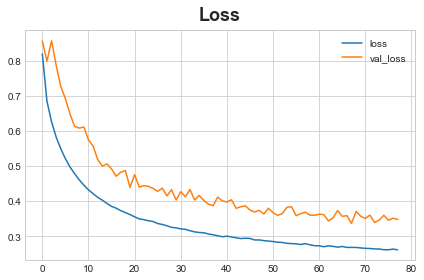

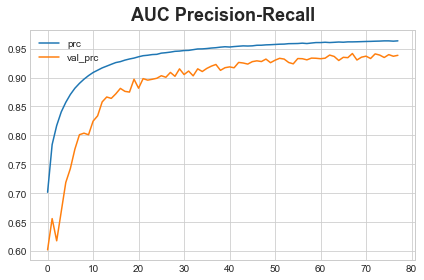

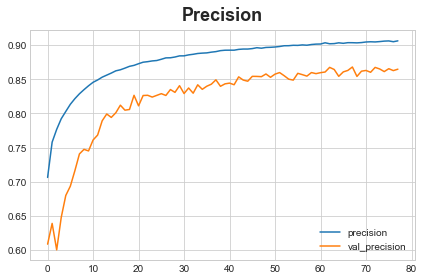

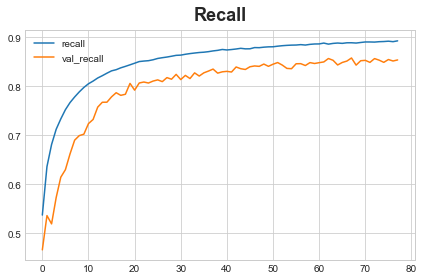

In [30]:
# analyze metrics
plot_metrics(history)

In [31]:
# analyze confusion matrix
plot_cm(valid_ds)

---Quality Metrics---
loss :  0.3366852104663849
tp :  38351.0
fp :  5843.0
tn :  83539.0
fn :  6340.0
binary_accuracy :  0.9091317057609558
precision :  0.8677874803543091
recall :  0.8581370115280151
auc :  0.9687634706497192
prc :  0.9414850473403931



# VI. Predict 

In [32]:
# reload model
model_path = "font_size.h5"
reloaded_model = keras.models.load_model(model_path)

In [33]:
test_sample = dict(X_train_SMOTE.iloc[6000])

In [34]:
y_train_SMOTE[6000]

array([0., 1., 0.])

In [36]:
sample = {
    'ppi':                    386.000000,
    'width_ratio':              0.551852,
    'height_ratio':             0.057207,
    'display_screen_size':      6.400000,
    'font_height':             38.000000,
    'char_width':              19.166667,
    'font_dp':                 15.800000,
    'density_bucket_0':         0.000000,
    'density_bucket_1':         1.000000,
    'density_bucket_2':         0.000000,
    'density_bucket_3':         0.000000,
    'density_bucket_4':         0.000000,
    'element_type_0':           0.000000,
    'element_type_1':           0.000000,
    'element_type_2':           0.000000,
    'element_type_3':           0.000000,
    'element_type_4':           0.000000,
    'element_type_5':           0.000000,
    'element_type_6':           0.000000,
    'element_type_7':           0.000000,
    'element_type_8':           0.000000,
    'element_type_9':           0.000000,
    'element_type_10':          0.000000,
    'element_type_11':          0.000000,
    'element_type_12':          0.000000,
    'element_type_13':          0.000000,
    'element_type_14':          0.000000,
    'element_type_15':          0.000000,
    'element_type_16':          0.000000,
    'element_type_17':          1.000000,
    'element_type_18':          0.000000,
    'element_type_19':          0.000000,
    'element_type_20':          0.000000,
    'element_type_21':          0.000000,
    'element_type_22':          0.000000,
    'screen_part_0':            0.000000,
    'screen_part_1':            1.000000,
    'screen_part_2':            0.000000,
    'screen_part_3':            0.000000
}
sample_dict = {name: tf.convert_to_tensor([value]) for name, value in test_sample.items()}
# print(sample_dict)
predictions = reloaded_model.predict(sample_dict)
predictions

1


array([[0., 1., 0.]], dtype=float32)